<a href="https://colab.research.google.com/github/AmanDesai-coder/CBCA_Ndosho_Electricity_Analysis/blob/main/AmanElectricityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: All work is based off of the kwh dataset initially created by Allison Wong.

First let's import the libraries we will need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import traces

Next, let's grab the dataframe from the GitHub link. If running locally, you may also use the local file path, but using the GitHub link allows you to run just this notebook without cloning the entire repo.

Some data values have a missing hour component, so we put in noon as a default.

In [2]:
electr_df = pd.read_csv("https://raw.githubusercontent.com/AmanDesai-coder/CBCA_Ndosho_Electricity_Analysis/main/kwh-virunga.csv")
electr_df['Heure'] = electr_df['Heure'].fillna("12:00") 
electr_df.head()

,Jour,Date,Heure,KwH Restant,Achat KwH
0,Mercredi,03-06-2020,18:30,500.0,0.0
1,Mercredi,03-06-2020,18:50,470.0,0.0
2,Jeudi,04-06-2020,8:00,420.0,0.0
3,Jeudi,04-06-2020,17:00,365.0,0.0
4,Vendredi,05-06-2020,8:00,310.0,0.0


In [3]:
electr_df["timestamp"] = electr_df["Date"] + [" "] + electr_df["Heure"]
electr_df["timestamp"] = pd.to_datetime(electr_df["timestamp"],format='%d-%m-%Y %H:%M')
electr_df = electr_df.drop(['Jour', 'Heure', 'Date'], axis = 1)
electr_df.head()

,KwH Restant,Achat KwH,timestamp
0,500.0,0.0,2020-06-03 18:30:00
1,470.0,0.0,2020-06-03 18:50:00
2,420.0,0.0,2020-06-04 08:00:00
3,365.0,0.0,2020-06-04 17:00:00
4,310.0,0.0,2020-06-05 08:00:00


The original column names are in French. We can use the pandas rename method to map these to English translations. Then, we sort the rows by timestamp so that the most recent data is at the end of the dataframe.

In [4]:
electr_df = electr_df.rename(columns = {'KwH Restant' : 'kwH Remaining', 'Achat KwH' : 'kwH Purchased'})
electr_df = electr_df.sort_values('timestamp').reset_index()
electr_df["Month"] = electr_df['timestamp'].apply(lambda x: x.month)
electr_df["Year"] = electr_df['timestamp'].apply(lambda x: x.year)
electr_df

,index,kwH Remaining,kwH Purchased,timestamp,Month,Year
0,0,500.00,0.0,2020-06-03 18:30:00,6,2020
1,1,470.00,0.0,2020-06-03 18:50:00,6,2020
2,2,420.00,0.0,2020-06-04 08:00:00,6,2020
3,3,365.00,0.0,2020-06-04 17:00:00,6,2020
4,4,310.00,0.0,2020-06-05 08:00:00,6,2020
...,...,...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00,2,2023
1489,1489,93.58,0.0,2023-02-06 17:35:00,2,2023
1490,1490,801.06,800.0,2023-02-07 14:50:00,2,2023
1491,1491,766.15,0.0,2023-02-07 17:20:00,2,2023


For each row, we calculate the total amount of electricity purchased at or before the corresponding timestamp. We then subtract the remaining kwH from that value for each row to get the total amount of electricity consumed at or before the corresponding timestamp.

In [5]:
electr_df['Total kwH Purchased'] = np.cumsum(electr_df['kwH Purchased'].values)
electr_df['Total kwH Consumed'] = electr_df['Total kwH Purchased'] - electr_df['kwH Remaining']
electr_df

,index,kwH Remaining,kwH Purchased,timestamp,Month,Year,Total kwH Purchased,Total kwH Consumed
0,0,500.00,0.0,2020-06-03 18:30:00,6,2020,0.00,-500.00
1,1,470.00,0.0,2020-06-03 18:50:00,6,2020,0.00,-470.00
2,2,420.00,0.0,2020-06-04 08:00:00,6,2020,0.00,-420.00
3,3,365.00,0.0,2020-06-04 17:00:00,6,2020,0.00,-365.00
4,4,310.00,0.0,2020-06-05 08:00:00,6,2020,0.00,-310.00
...,...,...,...,...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00,2,2023,145355.23,145066.42
1489,1489,93.58,0.0,2023-02-06 17:35:00,2,2023,145355.23,145261.65
1490,1490,801.06,800.0,2023-02-07 14:50:00,2,2023,146155.23,145354.17
1491,1491,766.15,0.0,2023-02-07 17:20:00,2,2023,146155.23,145389.08


Note that the first few values of the "Total kwH Consumed" column are negative. This is because the energy purchased before the survey began is not accounted for, even though it is that energy being used for the first few days. We adjust for this by adding the first value of the "kwH Remaining" column to the "Total kwH Consumed" column.

In [6]:
electr_df['Total kwH Consumed'] = electr_df['kwH Remaining'].iloc[0] + electr_df['Total kwH Consumed']
electr_df

,index,kwH Remaining,kwH Purchased,timestamp,Month,Year,Total kwH Purchased,Total kwH Consumed
0,0,500.00,0.0,2020-06-03 18:30:00,6,2020,0.00,0.00
1,1,470.00,0.0,2020-06-03 18:50:00,6,2020,0.00,30.00
2,2,420.00,0.0,2020-06-04 08:00:00,6,2020,0.00,80.00
3,3,365.00,0.0,2020-06-04 17:00:00,6,2020,0.00,135.00
4,4,310.00,0.0,2020-06-05 08:00:00,6,2020,0.00,190.00
...,...,...,...,...,...,...,...,...
1488,1488,288.81,0.0,2023-02-06 08:42:00,2,2023,145355.23,145566.42
1489,1489,93.58,0.0,2023-02-06 17:35:00,2,2023,145355.23,145761.65
1490,1490,801.06,800.0,2023-02-07 14:50:00,2,2023,146155.23,145854.17
1491,1491,766.15,0.0,2023-02-07 17:20:00,2,2023,146155.23,145889.08


Let's graph the data to see if there are any trends we can pick out.

<Axes: xlabel='timestamp'>

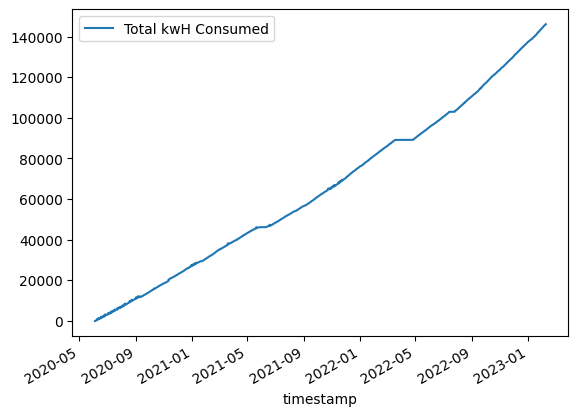

In [7]:
electr_df.plot('timestamp', 'Total kwH Consumed')

Looking at the graph above, the shape of the data seems roughly linear, but the slope of the curve gets noticeably steeper as time passes. This slope represents the rate of energy consumption, which is the variable we are most interested in.

Since the time series data we have is unevenly spaced, let's get it expressed in terms of regular intervals. Many time series analysis methods require evenly spaced data, so this gives us a much wider range of options. It also helps smooth out any outliers in the data caused by rapid energy changes over short time periods. The below method re-expresses the data with gaps of 1 day intervals via linear interpolation.

In [8]:
ts = traces.TimeSeries(list(electr_df[['timestamp', 'Total kwH Consumed']].itertuples(index=False, name=None)))
a = traces.TimeSeries(ts.sample(
    sampling_period=pd.Timedelta(days = 1),
    interpolate='linear'
))

time = pd.Series([x for x, y in a.items()])
cons = pd.Series([y for x, y in a.items()])

reg_df = pd.DataFrame({"Date" : time, "Total Energy Consumed (kwH)" : cons})

In [9]:
reg_df.head()

,Date,Total Energy Consumed (kwH)
0,2020-06-03 18:30:00,0.000000
1,2020-06-04 18:30:00,140.500000
2,2020-06-05 18:30:00,266.206897
3,2020-06-06 18:30:00,324.869302
4,2020-06-07 18:30:00,391.935349


We see that the data is in our desired format. Let's graph it to make sure that the regularization process did not alter its shape.

<Axes: xlabel='Date'>

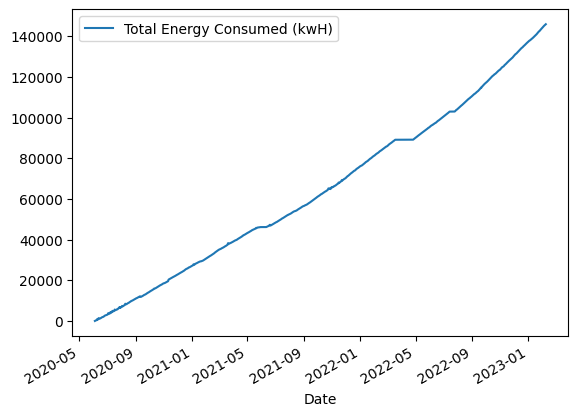

In [10]:
reg_df.plot('Date', 'Total Energy Consumed (kwH)')

Visually, the data seems almost indistinguishable from the original, which implies our regularization smoothed out the data without altering any of its trends.

Next, we calculate the slope (derivative) at each point using np.gradient. Note that this slope represents the daily energy use of the hospital.

In [11]:
reg_df['Daily Energy Consumption (kwH)'] = np.gradient(reg_df['Total Energy Consumed (kwH)'])
reg_df.head()

,Date,Total Energy Consumed (kwH),Daily Energy Consumption (kwH)
0,2020-06-03 18:30:00,0.000000,140.500000
1,2020-06-04 18:30:00,140.500000,133.103448
2,2020-06-05 18:30:00,266.206897,92.184651
3,2020-06-06 18:30:00,324.869302,62.864226
4,2020-06-07 18:30:00,391.935349,293.996258


Now, let's plot this data to see if there are any trends.

<Axes: xlabel='Date', ylabel='Daily Energy Consumption (kwH)'>

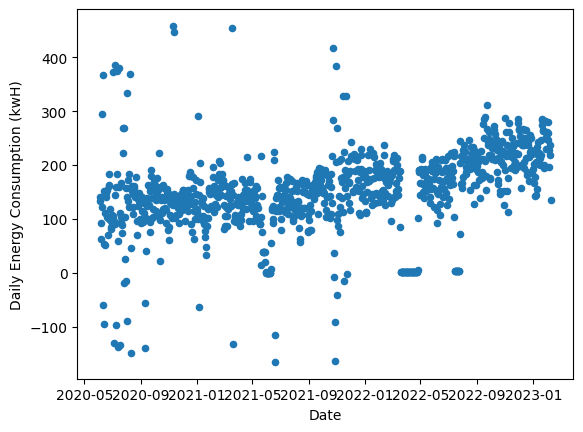

In [17]:
reg_df.plot('Date', 'Daily Energy Consumption (kwH)', kind = 'scatter')

The data is quite noisy, but definitely seems to have a positive trend. Let's try to fit it with a linear regression.

In [41]:
from statsmodels.tsa.arima.model import ARIMA

reg_df['Day'] = (reg_df['Date'] - reg_df['Date'].iloc[0]).apply(lambda x: x.days)

X = sm.add_constant(reg_df['Day'])
Y = reg_df['Daily Energy Consumption (kwH)']

lin_model = sm.OLS(Y, X, missing = 'drop').fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Daily Energy Consumption (kwH)   R-squared:                       0.119
Model:                                        OLS   Adj. R-squared:                  0.118
Method:                             Least Squares   F-statistic:                     132.0
Date:                            Tue, 06 Jun 2023   Prob (F-statistic):           9.65e-29
Time:                                    13:23:01   Log-Likelihood:                -5583.1
No. Observations:                             980   AIC:                         1.117e+04
Df Residuals:                                 978   BIC:                         1.118e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.1905      4.608     22.395      0.000      94.148     112.233
Day            0.0936      0.008     11.488      0.000       0.078       0.110
==============================================================================
Omnibus:                      131.949   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.287
Skew:                          -0.453   Prob(JB):                    6.61e-167
Kurtosis:                       7.233   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary above demonstrates that there is a statistically significant increase in the hospital's daily energy use over time. On average, the hospital's daily energy use increases by 0.09 kwH/day (ie. on average, the hospital uses 0.09 kwH more energy on a given day than on the day before.).

Let's graph the data and the regression line to get a picture of what this looks like.

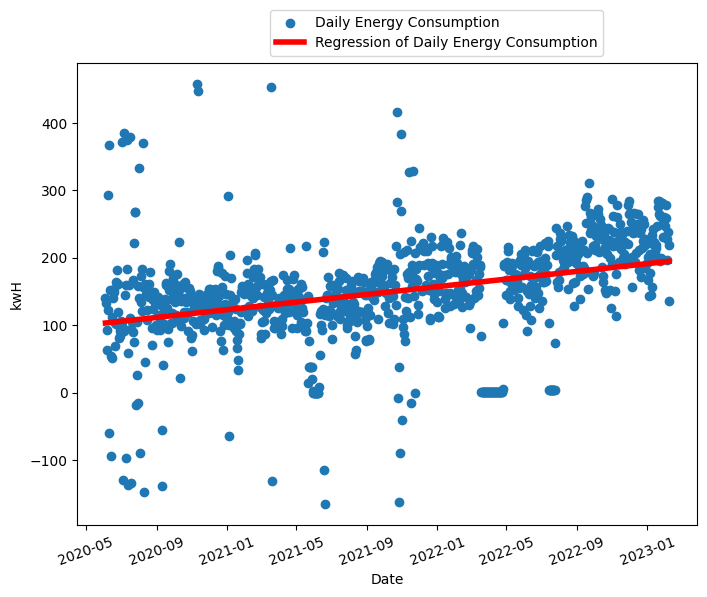

In [48]:
reg_df['Predicted Daily Energy Consumption (kwH)'] = lin_model.predict(X)

fig, ax = plt.subplots(figsize=(8, 6))

plt.xticks(rotation=20)

plt.xlabel("Date")
plt.ylabel("kwH")

plt.scatter(reg_df['Date'], reg_df['Daily Energy Consumption (kwH)'], label = 'Daily Energy Consumption')
plt.plot(reg_df['Date'], reg_df['Predicted Daily Energy Consumption (kwH)'], color = 'r', linewidth=4, label = 'Regression of Daily Energy Consumption')
plt.legend(bbox_to_anchor=(0.3, 1))



Above, we can see that the hospital's daily energy usage steadily increases over time. The regression line above illustrates this trend, and the miniscule P-value we got indicates this increase is statistically significant.

Note: Looking at the graph, there seems to be a sizable number of values showing negative daily energy usage. I am guessing this is either due to errors when entering the data or a mistake in my processing. 